In [2]:
import functions.add_path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import functions.et_preprocess as preprocess


import functions.pl_surface as pl_surface
from functions import et_import
from lib.pupil.pupil_src.shared_modules import accuracy_visualizer
from functions.pl_recalib import pl_recalibV2

import logging

/home/student/b/behinger/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


reached exception:pyaudio
reached exception:optimization_calibration
reached exception:glfw.GLFW_PRESS
reached exception:glfw.GLFW_KEY_SPACE
reached exception:glfw.GLFW_KEY_F
reached exception:glfw.glfwSetKeyCallback
reached exception:fingertip_calibration
reached exception:glfw.GLFW_PRESS
reached exception:natural_features_calibration
reached exception:optimization_calibration
reached exception:optimization_calibration
reached exception:glfw.GLFW_PRESS
reached exception:glfw.GLFW_KEY_SPACE
reached exception:glfw.GLFW_KEY_F
reached exception:glfw.glfwSetKeyCallback
reached exception:fingertip_calibration
reached exception:glfw.GLFW_PRESS
reached exception:natural_features_calibration
reached exception:optimization_calibration


In [197]:

def nbp_pupildetect(eye_id = None,folder=None,options = None,detector_type='2D'):
    import av
    import ctypes
    ctypes.cdll.LoadLibrary('/net/store/nbp/users/behinger/projects/etcomp/local/build/build_ceres_working/lib/libceres.so.2')
    import pupil_producers as pupil_produce
    import pupil_detectors
    from functions.pl_surface import fake_gpool_surface
    import pl_anna_tools
    from ui_roi import UIRoi

    
    #options = {"pupil_size_min":10,'pupil_size_max':150}
    
    
    
    cap = pl_anna_tools.init_playback(video_name = 'eye'+str(eye_id)+'.mp4',video_file_path = folder)

    
    #result = detector.detect(frame, UIRoi([frame.height,frame.width]), 0)
    if detector_type == '2D':
        detector = pupil_detectors.Detector_2D()
    elif detector_type == '3D':
        detector = pupil_detectors.Detector_3D()
    else:
        raise('unknowpln detectortype')
        
    if options:
        # XXX to be implemented after looking at what these parameters do.........
        for key in options.keys():
            assert key in detector.detectProperties.keys()



    results = [];
    for k in range(cap.get_frame_count()):
        cap.seek_to_frame(k)
        frame = cap.get_frame()
        result = detector.detect(frame, UIRoi([frame.height,frame.width]), 0)
        if result is not None:
            result['id'] = eye_id
        results.append(result)
    return(results)

In [198]:
pupil_positions_0_2d = nbp_pupildetect(detector_type = '2D',eye_id = 0,folder='/net/store/nbp/projects/etcomp/VP1/raw')
pupil_positions_1_2d = nbp_pupildetect(detector_type = '2D',eye_id = 1,folder='/net/store/nbp/projects/etcomp/VP1/raw')

Loading dummy calibration
error count: 64
error y=53 x=11
error count: 64
error y=51 x=14
error count: 64
error y=51 x=15
error count: 69
error y=52 x=20
Loading dummy calibration


In [199]:
pupil_positions_0_3d = nbp_pupildetect(detector_type = '3D',eye_id = 0,folder='/net/store/nbp/projects/etcomp/VP1/raw')
pupil_positions_1_3d = nbp_pupildetect(detector_type = '3D',eye_id = 1,folder='/net/store/nbp/projects/etcomp/VP1/raw')

Loading dummy calibration
error count: 64
error y=53 x=11
error count: 64
error y=51 x=14
error count: 64
error y=51 x=15
error count: 69
error y=52 x=20
Loading dummy calibration


In [200]:
pupil_positions_2d = pupil_positions_0_2d + pupil_positions_1_2d
pupil_positions_3d = pupil_positions_0_3d + pupil_positions_1_3d

In [105]:
from functions.et_import import raw_pl_data
original_pldata = raw_pl_data(subject="VP1")
original_pldata['pupil_positions_old'] = original_pldata['pupil_positions'] 


/net/store/nbp/projects/etcomp/VP1/raw/pupil_data


In [210]:
original_pldata['pupil_positions'] = pupil_positions_3d

In [61]:
# go throguh every note
for idx,note in enumerate(original_pldata['notifications']):
    # if we find a calibration
    if 'subject' in note.keys() and note['subject'] == 'calibration.calibration_data':
        # find first and last timestamp
        start = note['pupil_list'][0]['timestamp']
        stop  = note['pupil_list'][-1]['timestamp']
        # find the newly detected pupil data in this timeframe
        newpupil = [p for p in pupil_positions if start <= p['timestamp'] < stop]
        # overwrite it
        if len(newpupil)>0:
            print('%i - %.2f - %2.f'%(idx,start,stop))
            original_pldata['notifications'][idx]['pupil_list'] = newpupil
        else:
            print(idx)
        

In [217]:
def plot_et(dat,time=[2150,2250],normpos=0,eye=None,flip=False):
    dat = dat
    if type(eye) is not type(None):
        t = [p['timestamp'] for p in dat if p['id']==eye and time[0]< p['timestamp']<time[1]]
        ploty = [p['norm_pos'][normpos] for p in dat if p['id']==eye and time[0]< p['timestamp']<time[1]]
    else:
        t = [p['timestamp'] for p in dat if time[0]< p['timestamp']<time[1]]
        ploty = [p['norm_pos'][normpos] for p in dat if time[0]< p['timestamp']<time[1]]
    if flip:
        ploty = [1-p for p in ploty]
    plt.plot(t,ploty)
    plt.title("x/y:"+str(normpos)+" eye:" + str(eye))

    
    

In [214]:
type(None)

NoneType

In [206]:
# Checking whether newly detected pupil positions are identical
plt.figure()
def plt_pupil(original_pldata,eye,normpos):
    
    flip = False

    plot_et(original_pldata['pupil_positions_old'],normpos=normpos,eye=eye)
    plot_et(original_pldata['pupil_positions'],normpos=normpos,eye=eye,flip=flip)
    plt.ylim([0,1])
    

<Figure size 432x288 with 0 Axes>

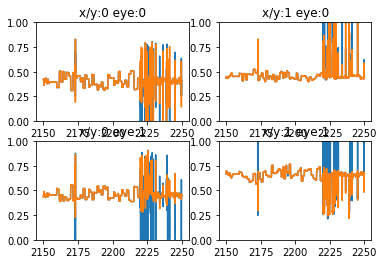

In [209]:
plt.subplot(2, 2, 1)
plt_pupil(original_pldata,0,0)
plt.subplot(2, 2, 2)
plt_pupil(original_pldata,0,1)
plt.subplot(2, 2, 3)
plt_pupil(original_pldata,1,0)
plt.subplot(2, 2, 4)
plt_pupil(original_pldata,1,1)

eye selected
eye selected


(0, 1)

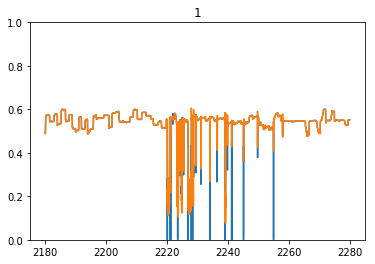

In [142]:
plt.figure()
plot_et(original_pldata['pupil_positions_old'],normpos=1,eye=0)
plot_et(original_pldata['pupil_positions'],normpos=1,eye=0)
plt.ylim([0,1])

In [211]:
# recalibrate!
from functions import nbp_recalib
original_pldata['gaze_positions_new'] = nbp_recalib.nbp_recalib(original_pldata)

Sorting pupil_positions
Calculating Recalibration Function
Calibration started at t=2040.86s and stopped at t=2092.86s, duration=52.00s
recalibrating for 689.51s, 162488 samples
6
Calculating Recalibration Function
Calibration started at t=2758.86s and stopped at t=2782.37s, duration=23.51s
recalibrating for 47.98s, 11366 samples
6
Calculating Recalibration Function
Calibration started at t=2783.17s and stopped at t=2830.35s, duration=47.18s
recalibrating for 558.21s, 131928 samples
6
Calculating Recalibration Function
Calibration started at t=3353.05s and stopped at t=3388.55s, duration=35.51s
recalibrating for 28.99s, 6859 samples
6
Calculating Recalibration Function
Calibration started at t=3390.04s and stopped at t=3417.54s, duration=27.50s
recalibrating for 643.62s, 152629 samples
6
Calculating Recalibration Function
Calibration started at t=4036.19s and stopped at t=4061.16s, duration=24.97s
recalibrating for 66.41s, 15658 samples
6
Calculating Recalibration Function
Calibration 

First iteration. root-mean-square residuals: 227.83443487435508 in pixel, this is bad!
The data cannot be represented by the model in a meaningfull way.
error


recalibrating for 29.01s, 6853 samples
6
Calibration failed: Paramters could not be estimated from data.
('calibration failed', [])
Calculating Recalibration Function
Calibration started at t=4519.89s and stopped at t=4547.84s, duration=27.95s
recalibrating for 456.55s, 108251 samples
6
Calculating Recalibration Function
Calibration started at t=4981.21s and stopped at t=5004.39s, duration=23.18s
recalibrating for 421.29s, 99811 samples
6
Calculating Recalibration Function
Calibration started at t=5400.78s and stopped at t=5425.68s, duration=24.90s
recalibrating for 350.90s, 83184 samples
6


(0.3, 0.6)

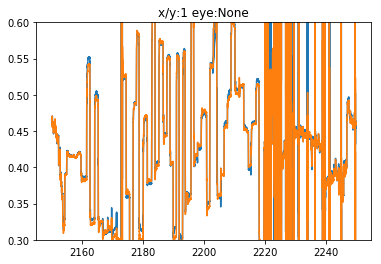

In [219]:
plt.figure()
plot_et(original_pldata['gaze_positions'],normpos=1)
plot_et(original_pldata['gaze_positions_new'],normpos=1)
plt.ylim([0,1])
plt.ylim([0.3,0.6])

In [4]:
%reload_ext autoreload
%autoreload 2

In [1]:
from functions.et_preprocess import preprocess_et
from functions.detect_events import make_blinks,make_saccades,make_fixations
from functions.detect_events_hmm import detect_events_hmm,detect_events_hmm_nosmooth
import logging
logger = logging.getLogger()

/home/student/b/behinger/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [10]:
logger.setLevel(logging.getLevelName('INFO'))

In [ ]:
from functions import et_helper
foldernames       = et_helper.get_subjectnames('/net/store/nbp/projects/etcomp/')
#TODO find out whats wrong with vp3 and vp12 and fix and then use vp3 again!!
rejected_subjects = ['pilot', 'log_files', 'surface', 'results','007', 'VP8', 'VP21','VP7','VP1']
subjectnames      = [subject for subject in foldernames if subject not in rejected_subjects]

for subject in subjectnames:
    etsamples, etmsgs, etevents = preprocess_et('pl',subject,load=False,
                                                       save=True,
                                                       eventfunctions=(make_blinks,make_saccades,make_fixations ),
                                                       outputprefix='3D',
                                                       pupildetect='3d')

/net/store/nbp/projects/etcomp/VP2/raw/pupil_data


In [ ]:
## etsamples,etmsgs,etevents = preprocess_et('pl',subject='', # don't use subject ETCOMP
                                          datapath='/net/store/nbp/projects/IntoTheWild/Daten/Eyetracking/Wild/VP21/2018_05_24/001', # full path 
                                          load=False, # just don't use this
                                          save=False, # Don't use this as you have multiple recordings! Would overwrite
                                          outputprefix='test', # for auto saving will name it etcomp_test ;)
                                          surfaceMap=False, # Detect surfaces? Only treadmill
                                          parsemsg=False, # ETCOMP parameter, don't use
                                          eventfunctions=(make_blinks,detect_events_hmm), # HMM function contains saccades + fixations
                                          px2deg=False, # don't convert, ETCOMP parameter
                                          pupildetect="3D" # redetect pupil (slow!, '2D' or '3D')
                                         )

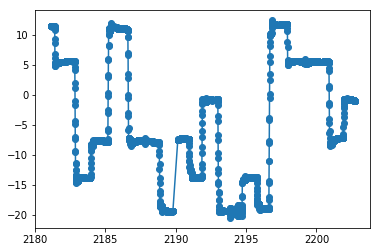

In [4]:
from matplotlib import pyplot as plt
plt.plot(etsamples.smpl_time.iloc[15000:20000],etsamples.gx.iloc[15000:20000],'o-')

In [5]:
    import pupil_detectors


In [12]:
pupil_detectors.detector_3d.Detector_3D()